In [1]:
import keras
from keras.datasets import mnist
from keras.models import load_model
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

from functools import partial

from collections import defaultdict

import isolearn.keras as iso

import os
import pickle
import numpy as np

import scipy.sparse as sp
import scipy.io as spio

import matplotlib.pyplot as plt

import tensorflow as tf

from keras.backend.tensorflow_backend import set_session

def contain_tf_gpu_mem_usage() :
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tf.Session(config=config)
    set_session(sess)

contain_tf_gpu_mem_usage()


Using TensorFlow backend.


In [2]:
#Load MNIST data

dataset_name = "mnist_3_vs_5"

img_rows, img_cols = 28, 28

num_classes = 10
batch_size = 32

included_classes = { 3, 5 }

(x_train, y_train), (x_test, y_test) = mnist.load_data()

keep_index_train = []
for i in range(y_train.shape[0]) :
    if y_train[i] in included_classes :
        keep_index_train.append(i)

keep_index_test = []
for i in range(y_test.shape[0]) :
    if y_test[i] in included_classes :
        keep_index_test.append(i)

x_train = x_train[keep_index_train]
x_test = x_test[keep_index_test]
y_train = y_train[keep_index_train]
y_test = y_test[keep_index_test]

n_train = int((x_train.shape[0] // batch_size) * batch_size)
n_test = int((x_test.shape[0] // batch_size) * batch_size)
x_train = x_train[:n_train]
x_test = x_test[:n_test]
y_train = y_train[:n_train]
y_test = y_test[:n_test]


x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)

input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

print("x_train.shape = " + str(x_train.shape))

print("n train samples = " + str(x_train.shape[0]))
print("n test samples = " + str(x_test.shape[0]))

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

#Binarize images

def _binarize_images(x, val_thresh=0.5) :
    
    x_bin = np.zeros(x.shape)
    x_bin[x >= val_thresh] = 1.
    
    return x_bin

x_train = _binarize_images(x_train, val_thresh=0.5)
x_test = _binarize_images(x_test, val_thresh=0.5)

digit_train = np.argmax(y_train, axis=1)
digit_test = np.argmax(y_test, axis=1)


x_train.shape = (11552, 28, 28, 1)
n train samples = 11552
n test samples = 1888


In [3]:
#Load predictor model

predictor = Sequential()

predictor.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape, name='conv2d_1'))
predictor.add(Conv2D(64, (3, 3), activation='relu', name='conv2d_2'))
predictor.add(MaxPooling2D(pool_size=(2, 2)))
predictor.add(Dropout(0.25))
predictor.add(Flatten())
predictor.add(Dense(128, activation='relu', name='dense_1'))
predictor.add(Dropout(0.5))
predictor.add(Dense(num_classes, activation='softmax', name='dense_2'))

predictor.load_weights('saved_models/mnist_binarized_cnn_10_digits.h5')
predictor.trainable = False

predictor.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer=keras.optimizers.Adadelta(),
    metrics=['accuracy']
)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [4]:
#Generate (original) predictions

pred_train = predictor.predict(x_train, batch_size=32)
pred_test = predictor.predict(x_test, batch_size=32)


In [5]:
from keras.layers import Input, Dense, Multiply, Flatten, Reshape, Conv2D, MaxPooling2D, GlobalMaxPooling2D, Activation
from keras.layers import BatchNormalization
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras import regularizers
from keras import backend as K

import tensorflow as tf
import numpy as np

from keras.layers import Layer, InputSpec
from keras import initializers, regularizers, constraints

class InstanceNormalization(Layer):
    def __init__(self, axes=(1, 2), trainable=True, **kwargs):
        super(InstanceNormalization, self).__init__(**kwargs)
        self.axes = axes
        self.trainable = trainable
    def build(self, input_shape):
        self.beta  = self.add_weight(name='beta',shape=(input_shape[-1],),
                                     initializer='zeros',trainable=self.trainable)
        self.gamma = self.add_weight(name='gamma',shape=(input_shape[-1],),
                                     initializer='ones',trainable=self.trainable)
    def call(self, inputs):
        mean, variance = tf.nn.moments(inputs, self.axes, keep_dims=True)
        return tf.nn.batch_normalization(inputs, mean, variance, self.beta, self.gamma, 1e-6)

def bernoulli_sampling (prob):
    """ Sampling Bernoulli distribution by given probability.

    Args:
    - prob: P(Y = 1) in Bernoulli distribution.

    Returns:
    - samples: samples from Bernoulli distribution
    """  

    n, x_len, y_len, d = prob.shape
    samples = np.random.binomial(1, prob, (n, x_len, y_len, d))

    return samples

class INVASE():
    """INVASE class.

    Attributes:
    - x_train: training features
    - y_train: training labels
    - model_type: invase or invase_minus
    - model_parameters:
      - actor_h_dim: hidden state dimensions for actor
      - critic_h_dim: hidden state dimensions for critic
      - n_layer: the number of layers
      - batch_size: the number of samples in mini batch
      - iteration: the number of iterations
      - activation: activation function of models
      - learning_rate: learning rate of model training
      - lamda: hyper-parameter of INVASE
    """

    def __init__(self, x_train, y_train, model_type, model_parameters):

        self.lamda = model_parameters['lamda']
        self.actor_h_dim = model_parameters['actor_h_dim']
        self.critic_h_dim = model_parameters['critic_h_dim']
        self.n_layer = model_parameters['n_layer']
        self.batch_size = model_parameters['batch_size']
        self.iteration = model_parameters['iteration']
        self.activation = model_parameters['activation']
        self.learning_rate = model_parameters['learning_rate']

        #Modified Code
        self.x_len = x_train.shape[1]
        self.y_len = x_train.shape[2]
        self.dim = x_train.shape[3] 
        self.label_dim = y_train.shape[1]

        self.model_type = model_type

        optimizer = Adam(self.learning_rate)

        # Build and compile critic
        self.critic = self.build_critic()
        self.critic.compile(loss='categorical_crossentropy', 
                            optimizer=optimizer, metrics=['acc'])

        # Build and compile the actor
        self.actor = self.build_actor()
        self.actor.compile(loss=self.actor_loss, optimizer=optimizer)

        if self.model_type == 'invase':
            # Build and compile the baseline
            self.baseline = self.build_baseline()
            self.baseline.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])


    def actor_loss(self, y_true, y_pred):
        """Custom loss for the actor.

        Args:
          - y_true:
            - actor_out: actor output after sampling
            - critic_out: critic output 
            - baseline_out: baseline output (only for invase)
          - y_pred: output of the actor network

        Returns:
          - loss: actor loss
        """
        
        y_pred = K.reshape(y_pred, (K.shape(y_pred)[0], self.x_len*self.y_len*1))
        y_true = y_true[:, 0, 0, :]

        # Actor output
        actor_out = y_true[:, :self.x_len*self.y_len*1]
        # Critic output
        critic_out = y_true[:, self.x_len*self.y_len*1:(self.x_len*self.y_len*1+self.label_dim)]

        if self.model_type == 'invase':
            # Baseline output
            baseline_out = \
            y_true[:, (self.x_len*self.y_len*1+self.label_dim):(self.x_len*self.y_len*1+2*self.label_dim)]
            # Ground truth label
            y_out = y_true[:, (self.x_len*self.y_len*1+2*self.label_dim):]        
        elif self.model_type == 'invase_minus':
            # Ground truth label
            y_out = y_true[:, (self.x_len*self.y_len*1+self.label_dim):]         

        # Critic loss
        critic_loss = -tf.reduce_sum(y_out * tf.log(critic_out + 1e-8), axis = 1)  

        if self.model_type == 'invase':        
            # Baseline loss
            baseline_loss = -tf.reduce_sum(y_out * tf.log(baseline_out + 1e-8), 
                                         axis = 1)  
            # Reward
            Reward = -(critic_loss - baseline_loss)
        elif self.model_type == 'invase_minus':
            Reward = -critic_loss

        # Policy gradient loss computation. 
        custom_actor_loss = \
        Reward * tf.reduce_sum(actor_out * K.log(y_pred + 1e-8) + \
        (1-actor_out) * K.log(1-y_pred + 1e-8), axis = 1) - \
        self.lamda * tf.reduce_mean(y_pred, axis = 1)

        # custom actor loss
        custom_actor_loss = tf.reduce_mean(-custom_actor_loss)

        return custom_actor_loss


    def build_actor(self):
        """Build actor.

        Use feature as the input and output selection probability
        """
        actor_model = Sequential()
        
        actor_model.add(Conv2D(self.actor_h_dim, (3, 3), padding='same', activation='linear'))
        actor_model.add(InstanceNormalization())
        actor_model.add(Activation(self.activation))
        for _ in range(self.n_layer - 2):
            actor_model.add(Conv2D(self.actor_h_dim, (3, 3), padding='same', activation='linear'))
            actor_model.add(InstanceNormalization())
            actor_model.add(Activation(self.activation))
        actor_model.add(Conv2D(1, (1, 1), padding='same', activation='sigmoid'))

        feature = Input(shape=(self.x_len, self.y_len, self.dim), dtype='float32')
        selection_probability = actor_model(feature)

        return Model(feature, selection_probability)


    def build_critic(self):
        """Build critic.

        Use selected feature as the input and predict labels
        """
        critic_model = Sequential()
        
        critic_model.add(Conv2D(self.critic_h_dim, (3, 3), padding='same', activation='linear'))
        critic_model.add(InstanceNormalization())
        critic_model.add(Activation(self.activation))
        for _ in range(self.n_layer - 2):
            critic_model.add(Conv2D(self.critic_h_dim, (3, 3), padding='same', activation='linear'))
            critic_model.add(InstanceNormalization())
            critic_model.add(Activation(self.activation))
        critic_model.add(Flatten())
        critic_model.add(Dense(self.critic_h_dim, activation=self.activation))
        critic_model.add(Dropout(0.2))
        critic_model.add(Dense(self.label_dim, activation ='softmax'))

        ## Inputs
        # Features
        feature = Input(shape=(self.x_len, self.y_len, self.dim), dtype='float32')
        # Binary selection
        selection = Input(shape=(self.x_len, self.y_len, 1), dtype='float32')         

        # Element-wise multiplication
        critic_model_input = Multiply()([feature, selection])
        y_hat = critic_model(critic_model_input)

        return Model([feature, selection], y_hat)


    def build_baseline(self):
        """Build baseline.

        Use the feature as the input and predict labels
        """
        baseline_model = Sequential()
        
        baseline_model.add(Conv2D(self.critic_h_dim, (3, 3), padding='same', activation='linear'))
        baseline_model.add(InstanceNormalization())
        baseline_model.add(Activation(self.activation))
        for _ in range(self.n_layer - 2):
            baseline_model.add(Conv2D(self.critic_h_dim, (3, 3), padding='same', activation='linear'))
            baseline_model.add(InstanceNormalization())
            baseline_model.add(Activation(self.activation))
        baseline_model.add(Flatten())
        baseline_model.add(Dense(self.critic_h_dim, activation=self.activation))
        baseline_model.add(Dropout(0.2))
        baseline_model.add(Dense(self.label_dim, activation ='softmax'))

        # Input
        feature = Input(shape=(self.x_len, self.y_len, self.dim), dtype='float32')       
        # Output        
        y_hat = baseline_model(feature)

        return Model(feature, y_hat)


    def train(self, x_train, y_train):
        """Train INVASE.

        Args:
          - x_train: training features
          - y_train: training labels
        """

        for iter_idx in range(self.iteration):

            ## Train critic
            # Select a random batch of samples
            idx = np.random.randint(0, x_train.shape[0], self.batch_size)
            x_batch = x_train[idx,:]
            y_batch = y_train[idx,:]

            # Generate a batch of selection probability
            selection_probability = self.actor.predict(x_batch)            
            # Sampling the features based on the selection_probability
            selection = bernoulli_sampling(selection_probability)     
            # Critic loss
            critic_loss = self.critic.train_on_batch([x_batch, selection], y_batch)                        
            # Critic output
            critic_out = self.critic.predict([x_batch, selection])

            # Baseline output
            if self.model_type == 'invase':   
              # Baseline loss
              baseline_loss = self.baseline.train_on_batch(x_batch, y_batch)                        
              # Baseline output
              baseline_out = self.baseline.predict(x_batch)

            ## Train actor
            # Use multiple things as the y_true: 
            # - selection, critic_out, baseline_out, and ground truth (y_batch)
            if self.model_type == 'invase':
                y_batch_final = np.concatenate((np.reshape(selection, (y_batch.shape[0], -1)), 
                                            np.asarray(critic_out), 
                                            np.asarray(baseline_out), 
                                            y_batch), axis = 1)
            elif self.model_type == 'invase_minus':
                y_batch_final = np.concatenate((np.reshape(selection, (y_batch.shape[0], -1)), 
                                            np.asarray(critic_out), 
                                            y_batch), axis = 1)

            y_batch_final = y_batch_final[:, None, None, :]
            
            # Train the actor
            actor_loss = self.actor.train_on_batch(x_batch, y_batch_final)

            if self.model_type == 'invase':
                # Print the progress
                dialog = 'Iterations: ' + str(iter_idx) + \
                     ', critic accuracy: ' + str(critic_loss[1]) + \
                     ', baseline accuracy: ' + str(baseline_loss[1]) + \
                     ', actor loss: ' + str(np.round(actor_loss,4))
            elif self.model_type == 'invase_minus':
                # Print the progress
                dialog = 'Iterations: ' + str(iter_idx) + \
                     ', critic accuracy: ' + str(critic_loss[1]) + \
                     ', actor loss: ' + str(np.round(actor_loss,4))

            if iter_idx % 100 == 0:
                print(dialog)

    def importance_score(self, x):
        """Return featuer importance score.

        Args:
          - x: feature

        Returns:
          - feature_importance: instance-wise feature importance for x
        """        
        feature_importance = self.actor.predict(x)        
        return np.asarray(feature_importance)


    def predict(self, x):
        """Predict outcomes.

        Args:
          - x: feature

        Returns:
          - y_hat: predictions    
        """        
        # Generate a batch of selection probability
        selection_probability = self.actor.predict(x)            
        # Sampling the features based on the selection_probability
        selection = bernoulli_sampling(selection_probability)   
        # Prediction 
        y_hat = self.critic.predict([x, selection])

        return np.asarray(y_hat)


In [6]:
#Create two-channel patterns for MNIST images

x_train_two = np.concatenate([
    1. - x_train,
    x_train
], axis=-1)

x_test_two = np.concatenate([
    1. - x_test,
    x_test
], axis=-1)


In [7]:
#Execute INVASE

mask_penalty = 5.#200.
hidden_dims = 32
n_layers = 5
epochs = 50
batch_size = 128

model_parameters = {
    'lamda': mask_penalty,
    'actor_h_dim': hidden_dims, 
    'critic_h_dim': hidden_dims,
    'n_layer': n_layers,
    'batch_size': batch_size,
    'iteration': int(x_train.shape[0] * epochs / batch_size), 
    'activation': 'relu', 
    'learning_rate': 0.0001
}

invase_model = INVASE(x_train_two, pred_train, 'invase', model_parameters)

invase_model.train(x_train_two, pred_train)    

importance_scores_test = invase_model.importance_score(x_test_two)


Instructions for updating:
Use tf.cast instead.
Iterations: 0, critic accuracy: 0.0546875, baseline accuracy: 0.09375, actor loss: 0.5301
Iterations: 100, critic accuracy: 0.765625, baseline accuracy: 0.9609375, actor loss: -126.7701
Iterations: 200, critic accuracy: 0.8984375, baseline accuracy: 0.9765625, actor loss: -55.4913
Iterations: 300, critic accuracy: 0.9375, baseline accuracy: 0.9921875, actor loss: -40.4428
Iterations: 400, critic accuracy: 0.9140625, baseline accuracy: 0.9921875, actor loss: -58.2112
Iterations: 500, critic accuracy: 0.953125, baseline accuracy: 0.9921875, actor loss: -31.0696
Iterations: 600, critic accuracy: 0.96875, baseline accuracy: 1.0, actor loss: -25.3682
Iterations: 700, critic accuracy: 0.9765625, baseline accuracy: 1.0, actor loss: -10.9407
Iterations: 800, critic accuracy: 0.9765625, baseline accuracy: 0.9921875, actor loss: -64.5081
Iterations: 900, critic accuracy: 0.9375, baseline accuracy: 0.9921875, actor loss: -70.2498
Iterations: 1000, c

In [8]:
#Evaluate INVASE model on train and test data

invase_pred_train = invase_model.predict(x_train_two)
invase_pred_test = invase_model.predict(x_test_two)

print("Training Accuracy = " + str(np.sum(np.argmax(invase_pred_train, axis=1) == np.argmax(pred_train, axis=1)) / float(pred_train.shape[0])))
print("Test Accuracy     = " + str(np.sum(np.argmax(invase_pred_test, axis=1) == np.argmax(pred_test, axis=1)) / float(pred_test.shape[0])))


Training Accuracy = 0.9846779778393352
Test Accuracy     = 0.9830508474576272


Test image 0:


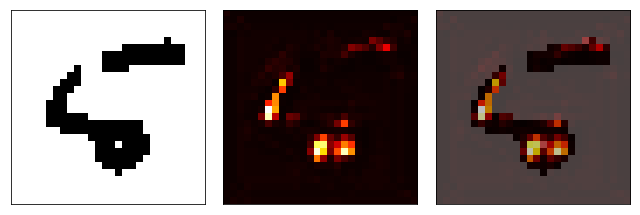

Test image 1:


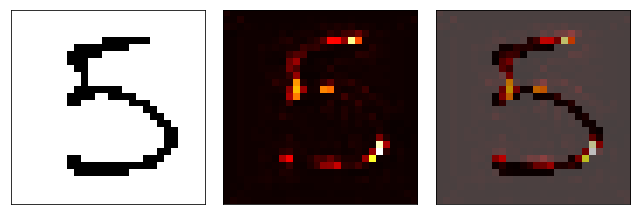

Test image 2:


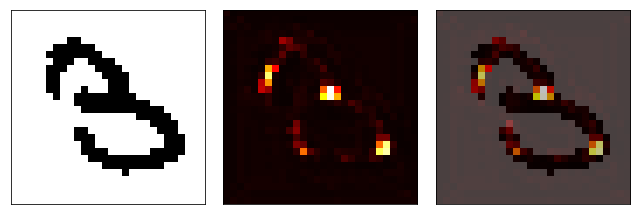

Test image 3:


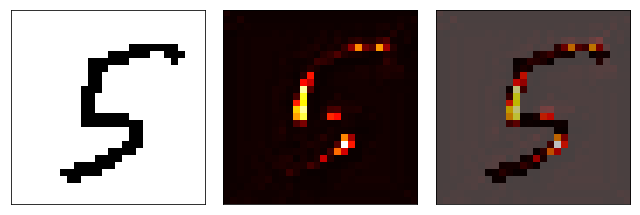

Test image 4:


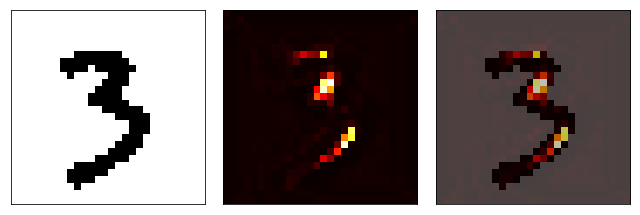

Test image 5:


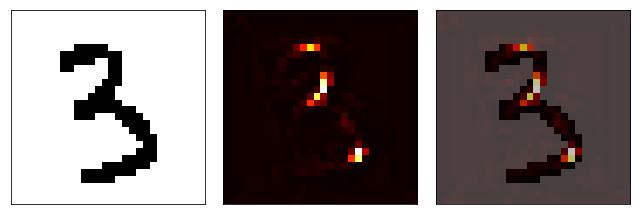

Test image 6:


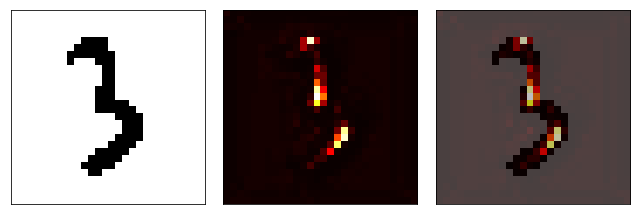

Test image 7:


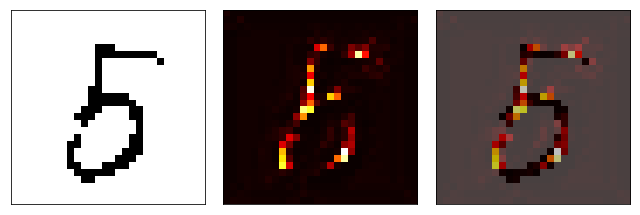

Test image 8:


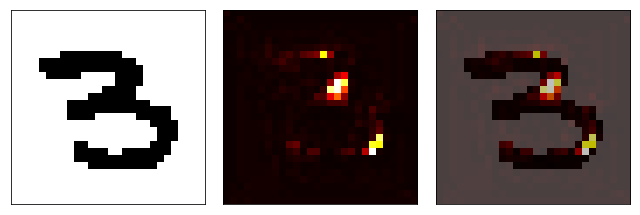

Test image 9:


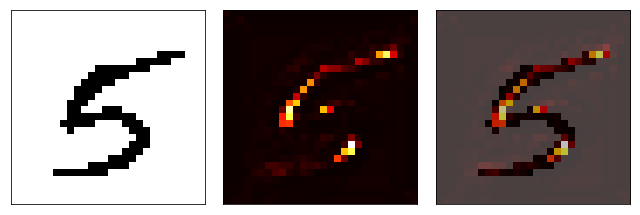

In [9]:
#Visualize a few images

for plot_i in range(0, 10) :
    
    print("Test image " + str(plot_i) + ":")
    
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(3 * 3, 3))

    ax1.imshow(x_test[plot_i, :, :, 0], cmap="Greys", vmin=0.0, vmax=1.0, aspect='equal')

    plt.sca(ax1)
    plt.xticks([], [])
    plt.yticks([], [])
    
    ax2.imshow(importance_scores_test[plot_i, :, :, 0], cmap="hot", vmin=0.0, vmax=max(1e-7, np.max(importance_scores_test[plot_i, :, :, 0])), aspect='equal')
    
    plt.sca(ax2)
    plt.xticks([], [])
    plt.yticks([], [])
    
    ax3.imshow(x_test[plot_i, :, :, 0], cmap="Greys", vmin=0.0, vmax=1.0, aspect='equal')

    ax3.imshow(importance_scores_test[plot_i, :, :, 0], alpha=0.75, cmap="hot", vmin=0.0, vmax=max(1e-7, np.max(importance_scores_test[plot_i, :, :, 0])), aspect='equal')
    
    plt.sca(ax3)
    plt.xticks([], [])
    plt.yticks([], [])

    plt.tight_layout()
    plt.show()


In [10]:
#Save predicted importance scores

model_name = "invase_" + dataset_name + "_conv"

np.save(model_name + "_importance_scores_test", importance_scores_test)
